![](https://cdn-images-1.medium.com/max/2000/1*YRINRZFr0E1FRJ4JpizEMw.jpeg)

This is my first time using PyTorch for Image Classification, this work is almost all taken from the work by Michael Diskin, the link to his amazing work is [here](https://www.kaggle.com/yhn112/resnet18-baseline-pytorch-ignite/notebook#Define-dataset-and-model).

In this notebook, we'll be classifying the images from 6 classes, we've used VGG19 architecture for this work, which gives us a ~90% training while ~89% test accuracy.

We have used PyTorch + ignite for this work.

If you find it useful in any way, don't forget to upvote. 

Thanks! :)

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
flag = 0
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        if flag == 5:
            break
        print(os.path.join(dirname, filename))
        flag += 1

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/intel-image-classification/seg_pred/seg_pred/8099.jpg
/kaggle/input/intel-image-classification/seg_pred/seg_pred/20135.jpg
/kaggle/input/intel-image-classification/seg_pred/seg_pred/11357.jpg
/kaggle/input/intel-image-classification/seg_pred/seg_pred/2447.jpg
/kaggle/input/intel-image-classification/seg_pred/seg_pred/17874.jpg


In [2]:
os.listdir("/kaggle/input/intel-image-classification/seg_train/seg_train")

['glacier', 'sea', 'forest', 'street', 'mountain', 'buildings']

In [3]:
from PIL import Image

import torch
import torch.nn as nn
import torch.utils.data as D
from torch.optim.lr_scheduler import ExponentialLR

from torchvision import models, transforms as T

from tqdm import tqdm_notebook

from glob import glob
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [4]:
from ignite.engine import Events, create_supervised_evaluator, create_supervised_trainer
from ignite.metrics import Loss, Accuracy
from ignite.contrib.handlers.tqdm_logger import ProgressBar
from ignite.handlers import  EarlyStopping, ModelCheckpoint

In [5]:
BASE_PATH = "/kaggle/input/intel-image-classification"
device = "cuda"
batch_size = 32
torch.manual_seed(0)

In [6]:
train_image_path_dict = {os.path.basename(x).split(".")[0] : x for x in glob(os.path.join(BASE_PATH, "seg_train", "seg_train", "*", "*.jpg"))}

In [7]:
test_image_path_dict = {os.path.basename(x).split(".")[0] : x for x in glob(os.path.join(BASE_PATH, "seg_test", "seg_test", "*", "*.jpg"))}

In [8]:
df_train = pd.DataFrame()
train_image_id = [os.path.basename(x).split(".")[0] for x in glob(os.path.join(BASE_PATH, "seg_train", "seg_train", "*", "*.jpg"))] 
df_train["image_id"] = train_image_id

In [9]:
df_test = pd.DataFrame()
test_image_id = [os.path.basename(x).split(".")[0] for x in glob(os.path.join(BASE_PATH, "seg_test", "seg_test", "*", "*.jpg"))]
df_test["image_id"] = test_image_id

In [10]:
df_train["path"] = df_train["image_id"].map(train_image_path_dict.get)

In [11]:
df_test["path"] = df_test["image_id"].map(test_image_path_dict.get)

In [12]:
df_train.path[0]

'/kaggle/input/intel-image-classification/seg_train/seg_train/glacier/1153.jpg'

In [13]:
df_test.path[0]

'/kaggle/input/intel-image-classification/seg_test/seg_test/glacier/20109.jpg'

In [14]:
df_train["target"] = df_train.path.apply(lambda x: x.split("/")[-2])

In [15]:
df_test["target"] = df_test.path.apply(lambda x : x.split("/")[-2])

In [16]:
le = LabelEncoder()
df_train["label"] = le.fit_transform(df_train["target"])

In [17]:
le.classes_

array(['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street'],
      dtype=object)

In [18]:
df_test["label"] = le.transform(df_test["target"])

In [19]:
temp = df_train.path.sample(6)
temp

7715     /kaggle/input/intel-image-classification/seg_t...
10042    /kaggle/input/intel-image-classification/seg_t...
9402     /kaggle/input/intel-image-classification/seg_t...
7637     /kaggle/input/intel-image-classification/seg_t...
609      /kaggle/input/intel-image-classification/seg_t...
11971    /kaggle/input/intel-image-classification/seg_t...
Name: path, dtype: object

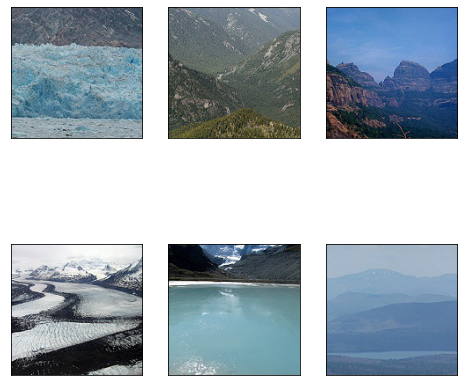

In [20]:
temp = df_train.path.sample(6)

fig=plt.figure(figsize=(8, 8))
columns = 3
rows = 2
for i in range(1, columns*rows +1):
    img = plt.imread(temp.iloc[i-1])
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
plt.show()

In [21]:
class ImagesDS(D.Dataset):
    def __init__(self, df, img_dir, mode = 'seg_train'):
        self.records = df.to_records(index = False)
        self.mode = mode
        self.img_dir = img_dir
        self.len = df.shape[0]
        
    @staticmethod
    def _load_img_as_tensor(file_name):
        with Image.open(file_name) as img:
            return T.Compose([T.Resize((150, 150)), T.RandomHorizontalFlip(), T.ToTensor(), T.Normalize((.5, .5, .5), (.5, .5, .5))])(img)

    def _get_img_path(self, index):
        image_id, target = self.records[index].image_id, self.records[index].target
        return '/'.join([self.img_dir,self.mode, self.mode, target, f"{image_id}.jpg"])
        
    def __getitem__(self, index):
        path = self._get_img_path(index)
        img = self._load_img_as_tensor(path)
        if self.mode == 'seg_train':
            return img, int(self.records[index].label)
        else:
            return img, self.records[index].image_id

    def __len__(self):
        return self.len

In [22]:
train_data, val_data = train_test_split(df_train, random_state = 42, test_size = 0.2)

In [23]:
ds = ImagesDS(train_data, BASE_PATH, mode = "seg_train")
ds_val = ImagesDS(val_data, BASE_PATH, mode = "seg_train")
ds_test = ImagesDS(df_test, BASE_PATH, mode = "seg_test")

In [24]:
classes = 6
model = models.vgg19(pretrained = True)
model.fc = nn.Linear(512, classes)

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/checkpoints/vgg19-dcbb9e9d.pth


In [25]:
loader = D.DataLoader(ds, batch_size = batch_size, shuffle = True, num_workers = 4)
val_loader = D.DataLoader(ds_val, batch_size = batch_size, shuffle = True, num_workers = 4)
test_loader = D.DataLoader(ds_test, batch_size = batch_size, shuffle = False, num_workers = 4)

In [26]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 3e-4, weight_decay = 0.0001)

In [27]:
metrics = { "loss" : Loss(criterion), "accuracy" : Accuracy()}

trainer = create_supervised_trainer(model, optimizer, criterion, device = device)
val_eval = create_supervised_evaluator(model, metrics = metrics, device = device)

In [28]:
@trainer.on(Events.EPOCH_COMPLETED)
def compute_and_display(engine):
    epoch = engine.state.epoch
    metrics = val_eval.run(val_loader).metrics
    print("Validation Results - Epoch: {}  Average Loss: {:.4f} | Accuracy: {:.4f} "
          .format(engine.state.epoch, 
                      metrics['loss'], 
                      metrics['accuracy']))

In [29]:
handler = EarlyStopping(patience = 5, score_function = lambda engine : engine.state.metrics['accuracy'], trainer = trainer)
val_eval.add_event_handler(Events.COMPLETED, handler)

In [30]:
checkpoints = ModelCheckpoint("models", "Model", n_saved = 3, create_dir = True)
trainer.add_event_handler(Events.EPOCH_COMPLETED, checkpoints, {"ResNet18" : model})

In [31]:
pbar = ProgressBar(bar_format = '')
pbar.attach(trainer, output_transform = lambda x : {"loss" : x})

In [32]:
trainer.run(loader, max_epochs = 50)

Validation Results - Epoch: 1  Average Loss: 0.4213 | Accuracy: 0.8561 


Validation Results - Epoch: 2  Average Loss: 0.5292 | Accuracy: 0.8247 


Validation Results - Epoch: 3  Average Loss: 0.3504 | Accuracy: 0.8896 


Validation Results - Epoch: 4  Average Loss: 0.3357 | Accuracy: 0.8960 


Validation Results - Epoch: 5  Average Loss: 0.3632 | Accuracy: 0.8760 


Validation Results - Epoch: 6  Average Loss: 0.4342 | Accuracy: 0.8671 


Validation Results - Epoch: 7  Average Loss: 0.2742 | Accuracy: 0.9063 


Validation Results - Epoch: 8  Average Loss: 0.3331 | Accuracy: 0.8860 


Validation Results - Epoch: 9  Average Loss: 0.2973 | Accuracy: 0.9020 


In [33]:
model.eval()
with torch.no_grad():
    preds = np.empty(0)
    for x, _ in tqdm_notebook(test_loader): 
        x = x.to(device)
        output = model(x)
        idx = output.max(dim=-1)[1].cpu().numpy()
        preds = np.append(preds, idx, axis=0)

In [34]:
preds = pd.Series(preds).astype(np.int)

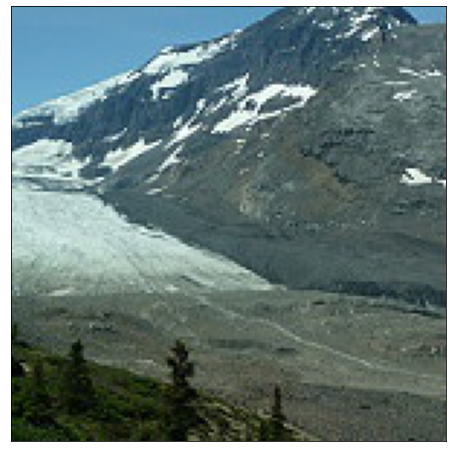

In [35]:
plt.rcParams["figure.figsize"] = [8, 8]
img = plt.imread(df_test.path[4])
plt.xticks([])
plt.yticks([])
plt.imshow(img)

In [36]:
df_test.path[4]

'/kaggle/input/intel-image-classification/seg_test/seg_test/glacier/21463.jpg'

In [37]:
for i in range(10):
    print(preds[i], df_test.label[i])

3 2
2 2
2 2
2 2
2 2
2 2
2 2
2 2
2 2
2 2


In [38]:
count = 0
for i in range(len(preds)):
    if df_test.label[i] == preds[i]:
        count += 1
        
print("Test accuracy: {}%".format((count/len(preds))*100))

Test accuracy: 85.7%
